<h1 style='text-align: center;'>HousePrices Regression</h1><br>
<p>Hello!<br><br>This is my first notebook. After studying some notebooks of this competition, I summarized the overall basic process of regression analysis. This kernel introduces the following.</p>
<ol>
    <li><b>Data EDA</b><br>
The process of searching for data is the most important step in analysis.<br>
I will introduce how to define the type of each variable and how to identify and visualize the form.</li>
    <li><b>Preprocessing</b><br>
This part is the step of preprocessing each variable based on the EDA results.<br>
I will introduce preprocessing tasks such as outlier processing, missing value processing, derivative variable generation, and variable conversion.</li>
    <li><b>Optimization (GridSearch, Optuna)</b><br>
The more complex the model is, the more complex the hyperparameter setting is required.<br>
Hyperparameter combinations can have a significant impact on the performance of the model.<br>
I will introduce how to optimize the hyperparameters of the model using GridSearchCV and Optuna.</li>
    <li><b>Modeling</b><br>
This part is the step of creating and learning basic models that can be used for regression analysis.<br>
I will use linear regression models such as Lasso and Ridge, SVM, and some tree-based algorithms. And I will use Stacking to maximize generalization performance.</li>
</ol>

<h2 style="text-align:center;">Module import</h2>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 5000)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge as krr
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as rfr, GradientBoostingRegressor as gbr
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.cluster import DBSCAN

import optuna
from functools import partial

<h2 style="text-align:center;">Load Data</h2>

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
print(f'train size: {train.shape}')
print(f'test size: {test.shape}')

train size: (1460, 81)
test size: (1459, 80)


<h1 style="text-align:center;">EDA</h1>

<h3 style="text-align:center;">1. Exploring dependent variables</h3><br>
<h4>Outline</h4>
The dependent variable is a continuous variable. The goal is to solve the regression analysis problem.<br>
In order to improve the performance of the linear models, the dependent variables and residuals must satisfy <b>'normality'</b>.<br><br>

<h4>Normality</h4>
Normality means that the distribution of variables follows a normal distribution.<br>
The easiest way to test normality is to draw a histogram and a QQ plot.<br>
It is recommended that the histogram form a bell shape. It is good to understand to see skewness and kurtosis together.<br>
I thought that if skewness is between 0 and 0.5 and kurtosis is between 1 and 8, the shape of the histogram is similar to that of a bell.<br>
If there is a shape extending along the baseline to the top right in the QQ plot, we can see that the data has normality.<br><br>
If it violates normality, log transformation or boxcox transformation can be applied.

SalePrice's skew: 1.8828757597682129
SalePrice's kurt: 6.536281860064529


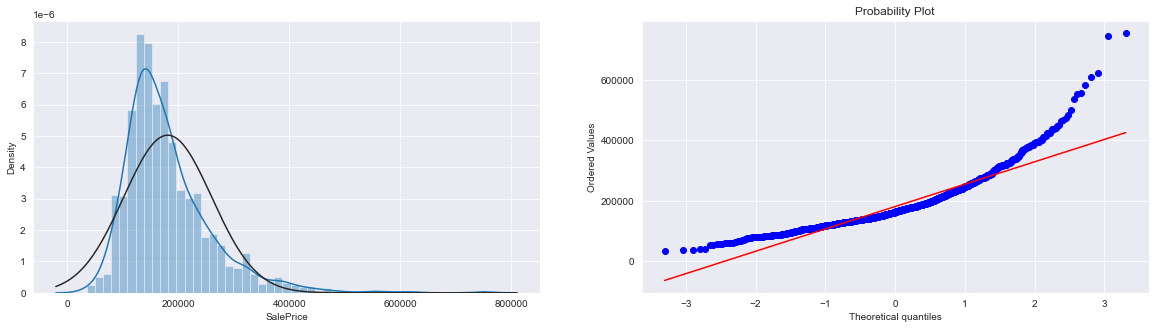

In [6]:
print(f"SalePrice's skew: {train.SalePrice.skew()}")
print(f"SalePrice's kurt: {train.SalePrice.kurt()}")
f, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(train.SalePrice, fit=norm, ax=ax[0])
probplot(train.SalePrice, plot=ax[1])
plt.show()

<p>
    <font color='red'>Conclusion:</font><br>
    Because the histogram is skewed to the left (skewness > 0), and the points of the QQ plot are out of the baseline,<br>
    It is necessary to convert to satisfy normality through variable transformation such as log transformation.
</p>

Check whether there is a missing value of the dependent variable.

In [7]:
print(f"SalePrice'missing count: {train.SalePrice.isnull().sum()}")

SalePrice'missing count: 0


<h3 style="text-align:center;">2. Exploring independent variables - Define Type</h3><br>
<h4>Outline</h4>
<p>
    Variable search means reading data_description and determining type of variables.<br>
    We can read the description of the variable, determine the type of variable, and further derive ideas for generating derived variables and converting data.<br><br>
    The types of variables are classified as follows.<br>
    <ol>
        <li>Categorical</li>
        <ol>
            <li>Nominal vars</li>
            <li>Order(Rank) vars</li>
        </ol>
        <li>Continuous</li>
        <ol>
            <li>Interval vars</li>
            <li>Ratio vars</li>
        </ol>
    </ol>
    The method of searching and preprocessing is determined by the type of variable.<br>
    <br>
    By using Pandas, we can find out the data type (numerical type and object) of the variable.<br>
    However, not all numerical variables can be determined as continuous variables.<br>
    I divided them subjectively by referring to data_description.<br>
    <br>
    Criteria (subjective)
    <ol>
        <li>
            Nominal type: Not related by category or item.<br>
            ex) Country, type
        </li>
        <li>
            Rank (order) type: Rank, order, and comparison are possible for each category and item.<br>
            ex) Grade, quality, etc.
        </li>
        <li>
            Continuous: A numerical variable that can be expressed continuously in a real interval.<br>
            ex) Feet, number, etc.
        </li>
    </ol>
</p>
Check numerical and object variables.

In [ ]:
num_vars = train.columns[train.dtypes != 'object']
obj_vars = train.columns[train.dtypes == 'object']

In [ ]:
pd.DataFrame(num_vars, columns=['num vars']).T

In [ ]:
pd.DataFrame(obj_vars, columns=['obj vars']).T

Explore some variables for example.<br><br>
<b>MSSubClass</b><br>
MSSubClass is a variable representing the type of residence.<br>
Although it is numerical, it is actually a categorical variable.<br>
I was able to read the description of each category in detail and find keywords representing 'order' like keywords such as 'Older' and 'Newer'.<br>
Therefore, MSSubClass was defined as an ordered variable.<br>
<br>
+Going further<br>
Looking at the description of MSSubClass, it can be seen that the category contains the following meanings.
1) Residential style.<br>
2) Years.<br>
3) The number of floors.<br><br>
The above items are all included in YearBuilt, HouseStyle, and BldgType, so they overlap.<br>
Instead, several categories have an additional meaning of 'PUD'.<br>
Therefore, it is possible to attempt to add a nominal derivative variable with a binary value based on PUD in the future.<br>
In addition, 1945 and 1946 often appear in explanations.<br>
Since this period may have an important domain meaning, it can be used when exploring YeaBuilt in the future.
<br><br>
<b>MSZoning</b><br>
MSZoning has a category. Each item is defined as a nominal variable because it does not have an order or ranking with each other.<br><br>
<b>LotFrontage</b><br>
LotFrontage is a continuous variable because it is a feet value.
<br><br>
<b>Street and Alley</b><br>
Street and Ally are nominal variables because there is no order and ranking.<br>
However, except for the NA value, They have Grvl or Pave. These variables are okay to be processed with ordered variables (applying label encoding instead of one hot encoding).<br><br>
+Going further<br>
Ally may have a negative meaning (NA) value.<br>
In the previous study, I learned that negative values can be recorded as missing values.<br>
Therefore, if there is a missing value, it can be directly replaced with a value such as None.
<br><br>
<b>OverallQual</b><br>
OverallQual is numerical but have categories.<br>
It can be seen that each item has a meaning related to quality. Therefore, it is a ranking variable.<br>
Ranked variables apply label encoding to preserve the meaning of values. However, there is no need to separately encode ranked variables that have already been expressed in sequential figures, such as 1 to 10.<br>
So I just included it in the continuous variable.
<br><br>
<b>ExterQual and ExterCond</b><br>
ExterQual and ExterCond are categories.
<br><br>
<b>BsmtFullBath and BsmtHalfBath</b><br>
In fact, the two variables commonly refer to the number of Bathrooms.<br>
I can think of creating a dataset with the same meaning as fewer variables by combining variables with one variable (ex) BsmtFullBath + 0.5 * BsmtHalfBath).
<br><br>
<b>Fence</b><br>
Fence is categorical and can be defined as a ranking variable because the item has a quality-related meaning.<br>
However, it is divided into a private case and a Wood case.<br>
Therefore, I can think that I can divide it into Privacy and Wood.
<br><br>
<b>MoSold and YrSold</b><br>
I treated variables such as YearBuild and YearEmodAdd as continuous variables.<br>
But when I checked the number of values in MoSold and YrSold (I used value_counts), the number of values were small enough to be treated as order variables.<br>
Therefore, the two variables were defined as order variables.<br><br>
I conducted the above search for all variables (if there is anything wrong or better idea, please comment).<br><br>
Now we can define the types of all variables.

In [ ]:
nominal_vars = [
    'MSZoning', 'LandContour', 'Utilities',
    'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
    'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 
    'GarageType', 'MiscFeature', 
    'SaleType', 'SaleCondition'
]

In [ ]:
order_vars = [
    'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
    'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'Street', 'Alley',
    'LandSlope', 'Functional', 'GarageFinish', 'MoSold', 'YrSold', 'PavedDrive', 
    'CentralAir', 'LotShape', 'MSSubClass', 
]

In [11]:
continuous_vars = [
    'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 
    'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
    'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
    'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'
]

+After determining the types of all variables, I checked if there were any missing variables.<br><br>
I compared the number of columns in the training set with the sum of self-defined variables and found that the number was different(Except Id, SalePrice).<br>
I found in the data_description that the variables expressed in Bedroom and Kitchen are actually Bedroom AbvGr and Kitchen AbvGr. These were defined as continuous variables.

In [ ]:
len(train.columns) == (len(nominal_vars) + len(order_vars)
                       + len(continuous_vars)) + len(set(['Id', 'SalePrice']))

<p>
    <font color='red'>Conclusion:</font><br>
    We defined the types of all variables.<br>
    This process can be effective in the pretreatment part later.
</p>

<h3 style="text-align:center;">3. Exploring independent variables - Check the missing values</h3><br>
<h4>Outline</h4>
We need to make sure that missing values exist for all variables.<br>
isnull().Sum() can be used to find missing values.

In [14]:
all_data = pd.concat((train, test)).drop(['SalePrice'], axis=1)
cnt_missing = all_data.isnull().sum().sort_values(ascending=False)
cnt_percent = cnt_missing / all_data.shape[0]
missing_table = pd.DataFrame([cnt_missing, cnt_percent], 
                             index=['missing count', 'missing percent']).T
missing_table = missing_table[missing_table['missing count'] > 0]

In [15]:
missing_table.iloc[:20]

,missing count,missing percent
PoolQC,2909.0,0.996574
MiscFeature,2814.0,0.964029
Alley,2721.0,0.932169
Fence,2348.0,0.804385
FireplaceQu,1420.0,0.486468
LotFrontage,486.0,0.166495
GarageYrBlt,159.0,0.054471
GarageFinish,159.0,0.054471
GarageQual,159.0,0.054471
GarageCond,159.0,0.054471


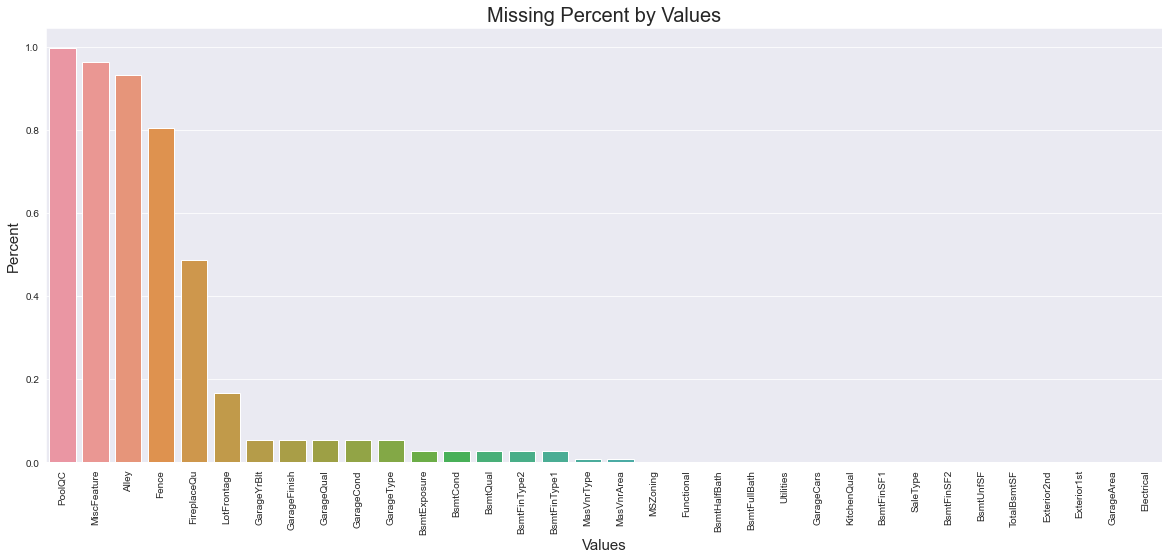

In [16]:
f, ax = plt.subplots(figsize=(20, 8))
sns.barplot(x=missing_table.index, y=missing_table['missing percent'])
plt.title('Missing Percent by Values', size=20)
plt.xlabel('Values', size=15)
plt.ylabel('Percent', size=15)
plt.xticks(rotation='90')
plt.show()

<p>
    <font color='red'>Conclusion:</font><br>
    Many variables have missing values.<br>
    Some variables have extremely large amounts of missing values.<br>
    We previously found category variables with negative meanings.<br>
    Maybe we can handle them easily.
</p>

<h3 style="text-align:center;">4. Exploring independent variables - distribution</h3><br>
I used histogram and barchat to see the distribution of continuous and categorical variables.

Draw a histogram of continuous variables.

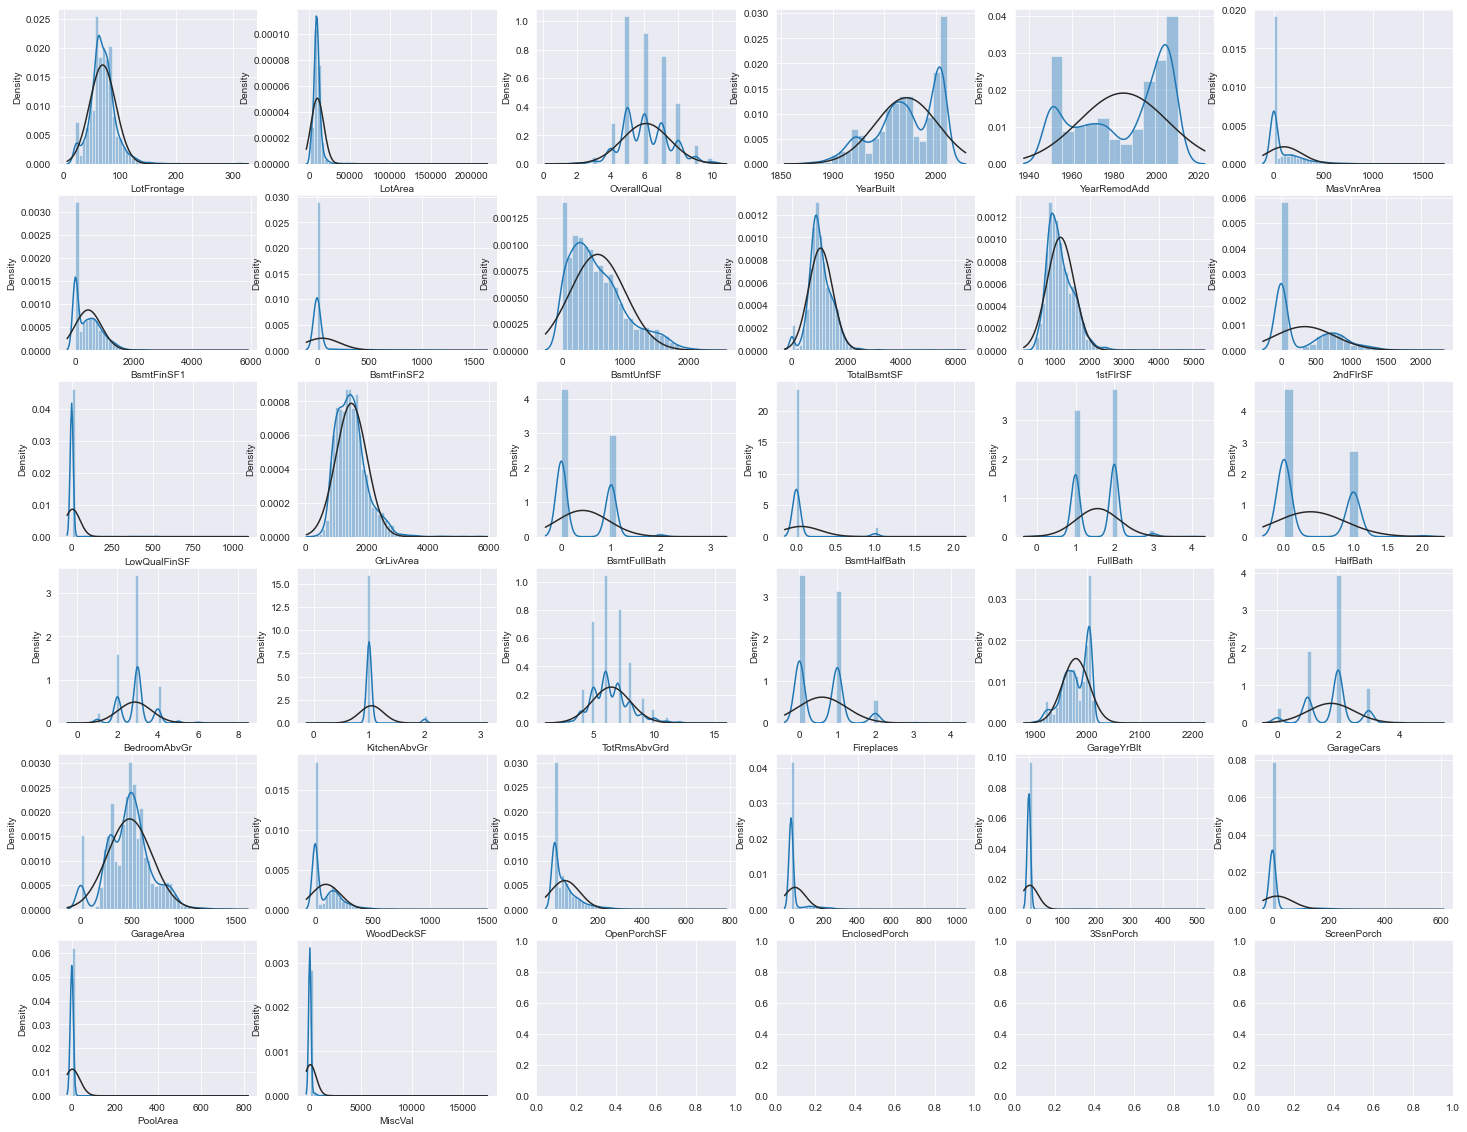

In [17]:
f, ax = plt.subplots(6, 6, figsize=(25, 20))
for i, c in enumerate(continuous_vars):
    sns.distplot(all_data[c], fit=norm, ax=ax[i//6, i%6])

Some variables seem to be able to follow a normal distribution through log transformation or box cox transformation. Some variables have zero. It seems that +1 should be done when converting.

Draw a bar chart for categorical variables.

Some variables were extremely biased toward one value (0). So they don't seem to be very important variables.

In [ ]:
f, ax = plt.subplots(5, 5, figsize=(25, 15))
for i, c in enumerate(nominal_vars):
    g = sns.barplot(data=pd.DataFrame(all_data[c].value_counts()).reset_index(), x='index', y=c, ax=ax[i//5, i%5])
    g.set(xticks=[])
    g.set(title=c)

<h3 style="text-align:center;">5. Bivariate search - correlation analysis, heat map, finding important variables</h3><br>
<h4>Outline</h4>
Correlation analysis is a technique to find out the correlation between the two variables.<br>
We can find variables with relatively strong <b>'linearity'</b> using the correlation coefficient with the dependent variable.<br>
I designated these variables as relatively important variables and tested <b>'homogeneity'</b>.<br>
In addition, I tested <b>'independence'</b> through the correlation between independent variables.<br>
<br>
<h4>Some assumptions for a good regression model</h4>
Previously, we checked the normality of the dependent variable and the residual.<br>
In addition, several more assumptions are needed.<br>
<ol>
    <li>
        <b>Linearity</b>:<br>
        It is recommended that the independent variable and the dependent variable have a linear relationship.<br>
        The 'variable transformation' or 'dimensional increase' method can help to have linearity.
    </li>
    <li>
        <b>homogeneity:</b>:<br>
        The variance of the residuals must be constant.<br>
        Drawing a residual diagram for an independent variable can test the equal variance.<br>
        If the points follow randomly based on the baseline, they satisfy the equal variance.
    </li>
    <li>
        <b>Independence</b>:<br>
        Independence means that there should be no correlation between independent variables.<br>
        The high correlation between independent variables causes multicollinearity. As a result, the performance of the model becomes incredible.
    </li>
    <li>
        <b>Irregularity</b>:<br>
        There should be no correlation between residuals.<br>
        Durbin-Watson' helps test for non-correlation.
    </li>
</ol>

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
highcorr_vars = (abs(train.corr().SalePrice).sort_values(ascending=False)[:7]).index
sns.heatmap(train[highcorr_vars].corr(), annot=True)
plt.show()

I selected only the top 10 variables with the highest correlation with the dependent variable and conducted the correlation analysis again.

"OverallQual" and "GrLiv Area" are the strongest variables.

Garage Cars and Garage Area are also highly correlated. High correlation between independent variables is not good because it causes multicollinearity.

In [ ]:
def hypo_test(x, y, cat=False):
    f, ax = plt.subplots(1, 4, figsize=(25, 5))
    if cat:
        sns.boxplot(x=train[x], y=train[y], ax=ax[0])
    else:
        sns.scatterplot(x=train[x], y=train[y], ax=ax[0])
        sns.regplot(x=train[x], y=train[y], ax=ax[0])
    sns.residplot(x=train[x], y=train[y], ax=ax[1])
    sns.distplot(train[x], fit=norm, ax=ax[2])
    probplot(train[x], plot=ax[3])
    plt.show()

I used the following chart for some tests.<br>
Scatter, Boxplot, resid plot, histogram, QQplot

In [ ]:
hypo_test('OverallQual', 'SalePrice', True)

In [ ]:
hypo_test('GrLivArea', 'SalePrice')

In [ ]:
hypo_test('GarageArea', 'SalePrice')

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(y=train.GarageArea, x=train.GarageCars, ax=ax[0])
sns.scatterplot(x=train['1stFlrSF'], y=train.TotalBsmtSF, ax=ax[1])
plt.show()

In [ ]:
skews = abs(all_data.skew()).sort_values(ascending=False)
kurts = abs(all_data.kurt()).sort_values(ascending=False)
skew_kurt_table = pd.DataFrame([skews, kurts], index=['skew', 'kurt']).T
ntv = skew_kurt_table[skew_kurt_table['skew'] > 0.5].index

plt.subplots(figsize=(15, 5))
sns.barplot(x=skew_kurt_table.loc[ntv].index, y=skew_kurt_table.loc[ntv]['skew'])
plt.xticks(rotation='90')
plt.title('skew by variable', size=20)
plt.xlabel('vars', size=15)
plt.ylabel('skew', size=15)
plt.show()

<p>
    <font color='red'>Conclusion:</font><br>
    I analyzed the correlation of each variable for SalePrice and confirmed that variables such as OverallQual, GrLivArea, and CarArea had high linearity.<br>
    Linearity was visualized using a box plot and scatter plot.<br>
    And I thought these variables were important variables, so I drew a residual diagram for the homodis variance test, a histogram for the normality test, and a QQ plot for them.<br>
    <br>
    Each variable does not satisfy the equal variance because the points of the residual degree are not randomly sprayed and have some pattern or shape.<br>
    I could see that each variable had no ideal normality through the results of the histogram and QQplot.<br>
    The above problems may be solved through log transformation or boxcox transformation.<br>
    <br>
    It was also confirmed that some independent variables were correlated with each other. As expected, I visualized it as a scatter plot.<br>
    The high correlation between independent variables causes multicollinearity. The explanatory power of the model loses its reliability.<br>
    I decided to use regulation rather than choosing variables or using dimension reduction right away.<br>
    The linear model may solve the above problem through regulation (normal1, normal2).<br>
    <br>
    It was difficult to visualize all variables, so I looked at the independent variables that required conversion through skewness and kurtosis.
</p>

Draw pair plot!

In [ ]:
sns.pairplot(train[highcorr_vars])
plt.show()

<h2 style='text-align: center'>Preprocessing</h2>

<h3 style="text-align:center;">1. Remove ID</h3><br>
<h4>Outline</h4>
I removed the ID variable that was not needed for analysis.

In [ ]:
train_id = train.Id
test_id = test.Id
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

<h3 style="text-align:center;">2. Clensing - Outlier</h3><br>
<h4>Outline</h4>
A dataset with outliers can degrade the performance of the model.<br>
It is optional to remove outliers existing in the training data. I found two outliers in the scatter plot of the variable with a strong correlation with the dependent variable.<br>
The two points were located in a place far off the straight line.<br><br>

<h4>Finding outliers</h4>
<ol>
    <li><b>Statistics for univariate - normal distribution, IQR:</b><br>For independent variables, points outside the threshold can be judged as outliers using normal distributions, likelihood functions, IQR, etc.<br>
        However, it cannot be judged that the point outside the threshold is always an outlier. For example, the scatterplot of GrLiv Area has two points apart at the top right.<br>
        These differ greatly in value from other points, but they are important because they can prove linearity.<br>Therefore, it is necessary to carefully deal with the determination of outliers for univariate quantities.</li>
    <li><b>Scattering point:</b><br>If you draw a scatterplot of two variables with a pattern (e.g., a linear relationship), you can intuitively find outliers.<br>
        I previously found some variables that have a strong correlation with the dependent variable. Two outliers were found through GrLiv Area's scatter plot.</li>
    <li><b>Clustering - DBSCAN:</b><br>DBSCAN can detect outliers using distance.<br>
        DBSCAN has a set range (epsilon) and required peripheral points (min_samples), and generates clusters by calculating key points and peripheral points.<br>
        Points that do not have key points around and do not have the minimum required neighboring points are outliers.<br>
        I applied scaling to GrLiv Area and SalePrice and tried DBSCAN.<br></li>
</ol>

In [ ]:
plt.subplots(figsize=(20, 10))
outlier_idx = train.GrLivArea.sort_values(ascending=False)[:2].index
sns.scatterplot(x=train['GrLivArea'], y=train.SalePrice)
sns.scatterplot(x=train.iloc[outlier_idx]['GrLivArea'], y=train.iloc[outlier_idx].SalePrice, color='r', s=300, alpha=.6)
plt.show()

In [ ]:
scaled_data = pd.DataFrame(StandardScaler().fit_transform(train[['GrLivArea', 'SalePrice']]), columns=['GrLivArea', 'SalePrice'])
dbscan_model = DBSCAN(eps=1.5, min_samples=3).fit(scaled_data)
tmp = pd.concat((scaled_data, pd.DataFrame(dbscan_model.labels_, columns=['label'])), axis=1)

In [ ]:
tmp.label.value_counts()

In [ ]:
sns.pairplot(tmp, hue='label', size=5)
plt.show()

In [ ]:
train.drop(train.GrLivArea.sort_values(ascending=False)[:2].index, axis=0, inplace=True)

<p>
    <font color='red'>Conclusion:</font><br>
    Two outliers were found through the scatterplot. Two points were removed.<br>
    In the case of DBSCAN, a total of 4 points were judged as outliers.
</p>

<h3 style="text-align:center;">3. Train, Test merge, separating dependent variables.</h3><br>
<h4>Outline</h4>
I removed outliers from the training data. Now I combine with the test data. The dependent variable is separated separately.

In [ ]:
train_size = train.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test), axis=0).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [ ]:
train.shape, test.shape, all_data.shape, y_train.shape

<h3 style="text-align:center;">4. Clensing - Missing Value</h3><br>
<h4>Outline</h4>
Missing values are objects that must be removed. The missing values are processed based on the understanding of each independent variable.
<br><br>
<h4>How to deal with missing values.</h4>
<ol>
    <li><b>Delete:</b><br>
        It is the easiest and most powerful way. Clear rows or columns. However, avoid erasing rows because missing values may also exist in the test data.<br>
        Clearing the columns risks removing important variables, so avoid them if possible.</li>
    <li><b>Replace a specific value:</b><br>
        It is a way to try if you have knowledge of variables. For example, if there are extremely many missing values of iso-interstitial variables that can have negative meanings,<br>
        Missing values are likely to have a negative meaning.
    <li><b>Replacement of central propensity:</b><br>
        It can be replaced with a central tendency value such as an average, a median value, and a minimum value. It is possible to replace the continuous variable with the median value and the category variable with the lowest value.</li>
    <li><b>Other than that: Simple probability replacement, multiple confrontation method, etc.</b><br>
</ol>
After looking at the explanation of each variable, I treated it as follows.<br>
<ul>
    <li>
        Continuous: Select one relevant category variable and replace the median for each category.<br>or
        Alternate to 0 if it is bound to be a missing value.
    </li>
    <li>
        Category type: value_counts to identify the distribution and replace it with None if there is zero negative meaning, such as NA or POOL. or<br>Select one related category variable, identify the distribution of values for each category, and replace the poorest value.
    </li>
</ul>

<p>
    Variables that are currently missing.
</p>

In [ ]:
all_data.columns[all_data.isnull().sum() > 0]

ex1) LotFrontage is replaced by the median value per Neighborhood.

In [ ]:
sns.scatterplot(x=all_data.Neighborhood, y=all_data.LotFrontage)
plt.xticks(rotation='90')
plt.show()

ex2) Ally is a ranking variable that can have NA, and since these values have been treated as missing values, replace them with None.

In [ ]:
all_data.Alley.value_counts()

ex3) Utilities are extremely skewed to AllPub, so replace them with the lowest value.

In [ ]:
all_data.Utilities.value_counts()

ex4) Garage Area is a missing value in the absence of Garage, so it is replaced by 0.

In [ ]:
all_data.GarageArea.value_counts()

In [ ]:
#all_data.MSZoning = all_data.groupby('Neighborhood').MSZoning.transform(lambda x: x.fillna(x.mode()[0]))
all_data.LotFrontage = all_data.groupby('Neighborhood').LotFrontage.transform(lambda x: x.fillna(x.median()))
#all_data.Exterior1st = all_data.groupby('Neighborhood').Exterior1st.transform(lambda x: x.fillna(x.mode()[0]))
#all_data.Exterior2nd = all_data.groupby('Neighborhood').Exterior2nd.transform(lambda x: x.fillna(x.mode()[0]))

for c in ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
          'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
          'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']:
    all_data[c] = all_data[c].fillna('None')
    
for c in ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
         'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']:
    all_data[c] = all_data[c].fillna(0)   
    
for c in ['MSZoning', 'Exterior1st', 'Exterior2nd', 'Electrical', 'Utilities', 'SaleType', 'Functional', 'KitchenQual']:
    all_data[c] = all_data[c].fillna(all_data[c].mode()[0])

In [ ]:
all_data.isnull().sum().sum()

<h3 style="text-align:center;">5. Derivative variable generation</h3><br>

Derivative variables are methods that can improve the quality of analysis. There are several ideas for how to generate derivative variables.

It is a continuous variable and means an observation of an object, and if this value is 0, it means that there is no object.
Therefore, it is possible to add categorical variables as to whether or not the object is present. Categorical variables with binary values can be stored as 0 and 1.

If you can express continuous variables of the same series in association, use a four-line operation.
New variables can be created. It is similar to calculating BMI with height and weight.

The above judgment can be used using min and max values after describe.



In [ ]:
all_data['HasMasVnr'] = all_data.MasVnrArea.apply(lambda x: 1 if x else 0)
all_data['Has2ndFlrSF'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x else 0)
all_data['HasGarageArea'] = all_data['GarageArea'].apply(lambda x: 1 if x else 0)
all_data['HasWoodDeckSF'] = all_data['WoodDeckSF'].apply(lambda x: 1 if x else 0)
all_data['HasOpenPorchSF'] = all_data['OpenPorchSF'].apply(lambda x: 1 if x else 0)
all_data['HasEnclosedPorch'] = all_data['EnclosedPorch'].apply(lambda x: 1 if x else 0)
all_data['Has3SsnPorch'] = all_data['3SsnPorch'].apply(lambda x: 1 if x else 0)
all_data['HasScreenPorch'] = all_data['ScreenPorch'].apply(lambda x: 1 if x else 0)
all_data['HasPoolArea'] = all_data['PoolArea'].apply(lambda x: 1 if x else 0)
all_data['HasMiscVal'] = all_data['MiscVal'].apply(lambda x: 1 if x else 0)

all_data['TotalBath'] = all_data['BsmtFullBath'] + all_data['BsmtHalfBath'] * 0.5\
+ all_data['FullBath'] + all_data['HalfBath'] * 0.5
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'] + all_data['BsmtFinSF1'] \
+ all_data['BsmtFinSF2']

<h3 style="text-align:center;">6. Select variables</h3><br>
Using variable selection can help improve the performance of the model.<br>
There are various approaches to the variable selection method, but I removed only a few variables that were most simply biased to one side.<br>

In [ ]:
nominal_vars = list(set(nominal_vars) - set(['Utilities']))
#order_vars = list(set(order_vars) - set(['Utilities']))
all_data.drop(['Utilities'], axis=1, inplace=True)

In [ ]:
# nominal_vars = list(set(nominal_vars) - set(['Utilities', 'PoolQC', 'PoolArea', 'Street']))
# order_vars = list(set(order_vars) - set(['Utilities', 'PoolQC', 'PoolArea', 'Street']))
# all_data.drop(['Utilities', 'PoolQC', 'PoolArea', 'Street'], axis=1, inplace=True)

<h3 style="text-align:center;">7. Transform variables</h3><br>
Log and boxcox transformations are applied to secure the normality and equal variance of continuous variables.<br>
Label encoding is applied to ordered (priority) variables.<br>
One-hot encoding is applied to equal variables.<br>
Log transformation is applied to the dependent variable to secure the normality of the dependent variable.

In [ ]:
all_data[nominal_vars] = all_data[nominal_vars].astype(str)
all_data[order_vars] = all_data[order_vars].astype(str)

In [ ]:
for c in order_vars:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [ ]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()

In [ ]:
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [ ]:
all_data = pd.get_dummies(all_data)

In [ ]:
y_train = np.log1p(y_train)

<h3 style="text-align:center;">7. Training, test data division</h3><br>
Divide the training data and test data again.

In [ ]:
X_train, X_test = all_data.iloc[:train_size, :], all_data.iloc[train_size:, :]

In [ ]:
X_train.shape, X_test.shape, y_train.shape

<h2 style="text-align:center;">Optimization (GridSearch, Optuna)</h2><br>
In order to maximize the performance of the model, the process of finding the appropriate hyperparameters is required. I used GridSearch to find hyperparameters for each model.
<br><br>
Sklearn's GridSearchCV was used for Laso, Ridge, ElasticNet, and SVM, and Optuna was used for tree-based models.

In [ ]:
def rmsle_cv(model):
    return np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error',
                   cv=5, verbose=0, n_jobs=-1))

<h3 style="text-align:center;">1. GridSearch Cross Validation</h3><br>

In [ ]:
model_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso())
])
model_elasticNet = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ElasticNet(max_iter=5000))
])
model_krr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', krr())
])

model_svr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', SVR())
])

grid_param_lasso = {
    'model__alpha': 0.0001 * np.arange(1, 100)
}
grid_param_elasticNet = {
    'model__alpha': 0.0001 * np.arange(1, 100),
    'model__l1_ratio': 0.001 * np.arange(1, 10)
}
grid_param_krr = {
    'model__alpha': 0.0001 * np.arange(1, 100),
    'model__degree': [1, 2, 3],
    'model__kernel': ['polynomial'],
    'model__coef0': [2.5]
}
grid_param_svr = {
    'model__C': [0.001, 0.1, 1, 10, 20],
    'model__gamma': [.0001, .0002, .0003, .0004, .0005, .0006, .0007, .0008, .0009, .001],
    'model__epsilon': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1]
}

best_params = {}

In [ ]:
search_lasso = GridSearchCV(model_lasso, grid_param_lasso, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
best_params['Lasso'] = search_lasso.best_params_

In [ ]:
search_elasticNet = GridSearchCV(model_elasticNet, grid_param_elasticNet, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
best_params['ElasticNet'] = search_elasticNet.best_params_

In [ ]:
search_krr = GridSearchCV(model_krr, grid_param_krr, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
best_params['KernelRidge'] = search_krr.best_params_

In [ ]:
search_svr = GridSearchCV(model_svr, grid_param_svr, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
best_params['SVR'] = search_svr.best_params_

<h3 style="text-align:center;">2. Optuna</h3><br>

<p>
The hyperparameters of tree models are diverse and have many combinations. Their optimization takes a lot of time.

So, I looked for XGBoost's hyperparameters using the Optuna package using early stopping and cross validation.

The hyperparameters of tree models are diverse and have many combinations. Their optimization takes a lot of time.

I looked for XGBoost's hyperparameters using the Optuna package using early stopping and cross validation.

Preparations: 'optuna', 'functions-partial', objective function

Pre-understanding:

Optuna is a framework that helps optimize hyperparameters. An objective function is required.

Optuna's objective function selects a new hyperparameter combination of the model every trial.

Optuna's study object is an object that performs optimization. The optimization of the study object requires a partial object and the number of attempts.

The partial object is an object that binds X, y with the objective function to be used by optuna.

Study objects store results that meet the purpose for each trial. Finally, remember the most purposeful hyperparameter combination.

The trial factor of objective embeds the function of specifying the range and value of hyperparameters. It has a hyperparameter name, range or list as a factor in common.
    <ol>
        <li><b>Suggest_int:</b> Select an integer value within the range.</li>
        <li><b>Suggest_uniform:</b> Select an equal distribution value within a range.</li>
        <li><b>Suggest_discrete_uniform:</b> Select a discrete uniform distribution value within the range.</li>
        <li><b>Suggest_loguniform:</b> Select a logarithmic function linear value within a range.</li>
        <li><b>Suggest_category:</b> Select a value in the list.</li>
    </ol>
</p>

In [ ]:
def objective_xgb(trial, X, y):
    param = {
        'n_estimators': 2000,
        'max_depth': trial.suggest_int('max_depth', 3, 11),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.005, 0.01),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 100),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 100),
        'n_jobs': -1
    }
    train_scores, test_scores = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = XGBRegressor(**param)
    for train_idx, test_idx in kf.split(X):
        tmp_X_train, tmp_X_test = X_train.iloc[train_idx, :], X_train.iloc[test_idx, :]
        tmp_y_train, tmp_y_test = y_train[train_idx], y_train[test_idx]
        model.fit(tmp_X_train, tmp_y_train,
                 eval_set=[(tmp_X_test, tmp_y_test)], eval_metric=['rmse'],
                 early_stopping_rounds=30, verbose=0,
                 callbacks=[optuna.integration.XGBoostPruningCallback(trial, observation_key='validation_0-rmse')])
        train_score = np.sqrt(mse(tmp_y_train, model.predict(tmp_X_train)))
        test_score = np.sqrt(mse(tmp_y_test, model.predict(tmp_X_test)))
        train_scores.append(train_score)
        test_scores.append(test_score)
    train_score = np.array(train_scores).mean()
    test_score = np.array(test_scores).mean()
    print(f'train score: {train_score}')
    print(f'test score: {test_score}')
    return test_score

In [ ]:
optimizer = partial(objective_xgb, X=X_train, y=y_train)
study = optuna.create_study(direction='minimize')
study.optimize(optimizer, n_trials=100)

Optuna can be used to visualize the optimal value for each trial or variable.

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
best_params['XGBoost'] = study.best_params

<h2 style="text-align:center;">Modeling</h2><br>

Create each model using the hyperparameter combination found earlier (Some parameters are corrected through several trials and errors).

In [ ]:
best_params

In [ ]:
model_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso(alpha=0.0005))
])

model_enet = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ElasticNet(alpha=0.0089, l1_ratio=0.009000000000000001, random_state=3))
])

model_krr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', krr(alpha=0.6,
                        kernel='polynomial',
                        degree=2,
                        coef0=2.5))
])
model_xgbr = XGBRegressor(colsample_bytree=0.4, learning_rate=0.00898718134841855, max_depth=8, 
                             n_estimators=2200, reg_alpha=0.036142628805195254, reg_lambda=0.03188665185506858,
                             subsample=0.6, random_state =42)
model_gbr = gbr(n_estimators=3000, learning_rate=0.009995774699700678,
                                   max_depth=8, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5)
model_lgbm = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
stack_gen = StackingCVRegressor(regressors=(model_lgbm, model_lasso, model_enet, model_krr, model_gbr),
                               meta_regressor=model_xgbr,
                               use_features_in_secondary=True)

Let's check the cross-validation results of each model.

In [ ]:
models = [
    model_lasso, model_enet, model_krr, model_gbr, model_xgbr, model_lgbm
]
cross_score = {
    'Lasso': 0,
    'ElasticNet': 0,
    'Kernel Ridge': 0,
    'GradientBoosting': 0,
    'XGBoost': 0,
    'LightGBM': 0,
}

for idx, model in enumerate(models):
    cross_score[list(cross_score.keys())[idx]] = rmsle_cv(model).mean()

In [ ]:
cross_score

After creating a blend function that can harmonize the results of multiple models, traning each model

In [ ]:
def blend(X):
    return ((0.15 * model_lasso.predict(X)) + \
            (0.15 * model_enet.predict(X)) + \
            (0.05 * model_krr.predict(X)) + \
            (0.15 * model_xgbr.predict(X)) + \
            (0.15 * model_lgbm.predict(X)) + \
            (0.35 * stack_gen.predict(np.array(X))))

In [ ]:
for model in models:
    model = model.fit(X_train, y_train)

In [ ]:
stack_gen = stack_gen.fit(X_train, y_train)

In [ ]:
np.sqrt(mse(y_train, blend(X_train)))

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = score = np.expm1(blend(X_test))
sub.to_csv('submission.csv',index=False)